I precedenti approcci sono stati utili per capire come modellare il dataset e quali modelli utilizzare al fine di ottenere risultati buoni su diversi tipi di metriche e scegliere i migliori, a seconda delle esigenza.
Come ultimo approccio si può pensare di limitare la previsione solo ed esclusivamente ai piccoli incendi, quindi in questo approccio verranno esclusi gli incendi grandi dal dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluation


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from scipy.stats import boxcox

In [2]:
pd.set_option('display.max_columns', None)

file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)
# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)
max_area = df['log_area'].max()

# CODIFICA MESI
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno


# CODIFICA GIORNI
enc_oneHot = preprocessing.OneHotEncoder()

arr = enc_oneHot.fit_transform(df[['day']]) 

# Conversione in array denso
dense_array = arr.toarray()
# Recuero nomi per le colonne
col_names = enc_oneHot.get_feature_names_out(['day'])
# Creazione DataFrame dalle colonne codificate da concatenare a quello originale
encoded_df = pd.DataFrame(dense_array, columns=col_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)
df.drop(columns=['day', 'month', 'area', 'month_encoded'], inplace=True)
df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'], inplace=True)

Il filtraggio verrà fatto insieme al preprocessing per gli outliers introdotto nella seconda versione.
Gli incendi sono limitati ad un massimo di 6.4 ettari circa.

In [3]:
# Copia del DataFrame originale, per non alterarlo direttamente
df_small_fires = df.copy()

small_fire_threshold = 2 # Logaritmico
max_area = small_fire_threshold
print(f"Small Fires: {(np.exp(max_area) - 1)} ha -> {(np.exp(max_area) - 1) / 100} km^2")

df_small_fires = df_small_fires[(df_small_fires['FFMC'] >= 50)]
df_small_fires = df_small_fires[(df_small_fires['DC'] > 0)]
df_small_fires = df_small_fires[(df_small_fires['ISI'] < 50)]
df_small_fires = df_small_fires[(df_small_fires['log_area'] <= small_fire_threshold)]


print(f"Dimensione originale del DataFrame: {df.shape}")
print(f"Dimensione del DataFrame senza outliers: {df_small_fires.shape}")

df_small_fires

Small Fires: 6.38905609893065 ha -> 0.06389056098930651 km^2
Dimensione originale del DataFrame: (517, 12)
Dimensione del DataFrame senza outliers: (381, 12)


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,1.153732,-0.866025
510,6,5,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.357674,-0.866025
511,8,6,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.000000,-0.866025
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025


MODELLI:

- LINEAR REGRESSOR:

Mean Absolute Error: 0.5434592909233102 -> km^2 = 0.007219533084614273
Train error (MAE): 0.5278251644400808
------------
Mean Squared Error: 0.39658607032997295
Root Mean Squared Error: 0.6297508001820823 -> km^2 = 0.008771427373453518
54 / 77 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 68.51%
------------
Accuracy in percentage (with a tolerance of 5.0%): 3.90%
Accuracy in percentage (with a tolerance of 10.0%): 9.09%
Accuracy in percentage (with a tolerance of 25.0%): 40.26%
Accuracy in percentage (with a tolerance of 50.0%): 87.01%


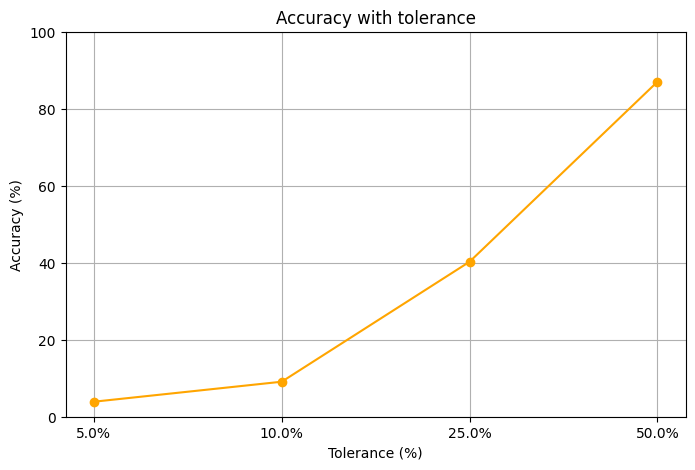

In [4]:
# LINEAR REGRESSOR

X = df_small_fires.drop(['log_area'], axis=1)  # Features
y = df_small_fires['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni  sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
print('- LINEAR REGRESSOR:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Best parameters: {'C': 0.01, 'gamma': 0.001}
- SVM:

Mean Absolute Error: 0.4010053357451644 -> km^2 = 0.004933252364816118
Train error (MAE): 0.4514826550657541
------------
Mean Squared Error: 0.44446350969154635
Root Mean Squared Error: 0.6666809654486517 -> km^2 = 0.00947761891478207
54 / 77 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 66.67%
------------
Accuracy in percentage (with a tolerance of 5.0%): 70.13%
Accuracy in percentage (with a tolerance of 10.0%): 71.43%
Accuracy in percentage (with a tolerance of 25.0%): 75.32%
Accuracy in percentage (with a tolerance of 50.0%): 80.52%


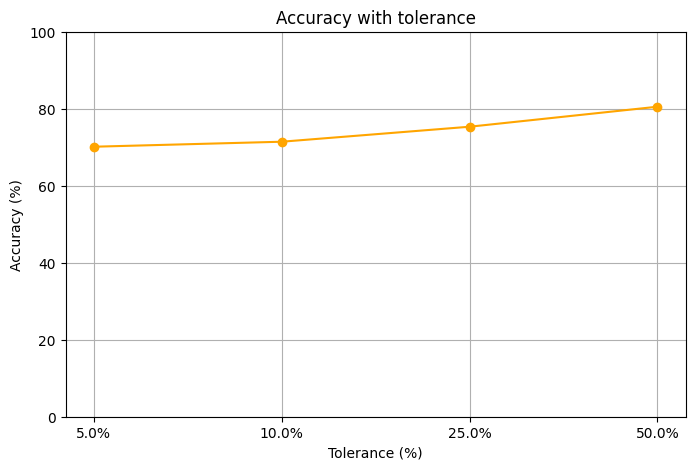

In [5]:
# SVM

X = df_small_fires.drop(['log_area'], axis=1)  # Features
y = df_small_fires['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = SVR(kernel='rbf')
#model.fit(X_train, y_train)

# Parametri da esplorare con GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],          # Penalità dell'errore
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]  # Flessibilità del kernel RBF
}
# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)


# Valutazione performace
print('- SVM:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
- NN:

Mean Absolute Error: 0.5698112089748067 -> km^2 = 0.00767933249994629
Train error (MAE): 0.4949121010403332
------------
Mean Squared Error: 0.48633460769587983
Root Mean Squared Error: 0.6973769480674564 -> km^2 = 0.010084774511997154
54 / 77 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 65.13%
------------
Accuracy in percentage (with a tolerance of 5.0%): 5.19%
Accuracy in percentage (with a tolerance of 10.0%): 14.29%
Accuracy in percentage (with a tolerance of 25.0%): 48.05%
Accuracy in percentage (with a tolerance of 50.0%): 84.42%


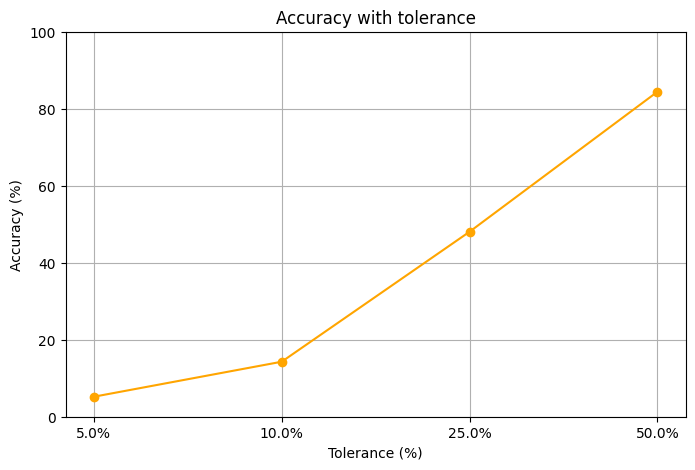

In [6]:
# NN 
X = df_small_fires.drop(['log_area'], axis=1)  # Features
y = df_small_fires['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = MLPRegressor(max_iter=1000, random_state=42)

# Parametri da ottimizzare
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],  # Diversi layer e dimensioni
    'activation': ['relu', 'tanh'],  # Funzioni di attivazione
    'solver': ['adam', 'sgd'],  # Algoritmi di ottimizzazione
    'alpha': [0.00001, 0.0001, 0.001, 0.01],  # Penalizzazione L2
    'learning_rate': ['constant', 'adaptive'],  # Velocità di apprendimento
}

# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=mae_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- NN:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
- GRADIENT BOOST REGRESSION:

Mean Absolute Error: 0.5167634653249213 -> km^2 = 0.006765925091411293
Train error (MAE): 0.2724502610475217
------------
Mean Squared Error: 0.4421657796682041
Root Mean Squared Error: 0.6649554719439521 -> km^2 = 0.009444039388816008
54 / 77 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 66.75%
------------
Accuracy in percentage (with a tolerance of 5.0%): 14.29%
Accuracy in percentage (with a tolerance of 10.0%): 27.27%
Accuracy in percentage (with a tolerance of 25.0%): 49.35%
Accuracy in percentage (with a tolerance of 50.0%): 80.52%


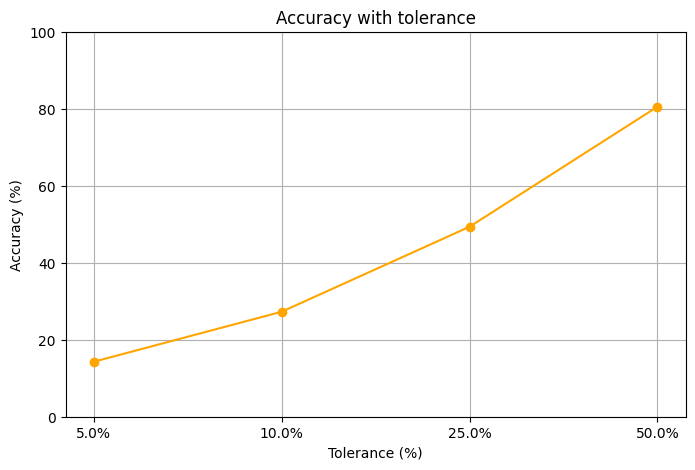

In [7]:
# GRADIENT BOOST REGRESSION
X = df_small_fires.drop(['log_area'], axis=1)
#X = df[['temp', 'RH', 'wind', 'rain']]
y = df_small_fires['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Parametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300, 500],        # Numero di alberi
    'learning_rate': [0.01, 0.1, 0.2],     # Velocità di apprendimento
    'max_depth': [3, 5, 7, 10],                # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],       # Minimo numero di campioni per split
    'min_samples_leaf': [1, 2, 4],         # Minimo numero di campioni in una foglia
}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Grid Search con validazione incrociata
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit dei dati di addestramento
grid_search.fit(X_train, y_train)

# Miglior modello
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- GRADIENT BOOST REGRESSION:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)